# Approche non supervisée

Nous allons tâcher de détecter les différents sujets traités dans le corpus via une approche non supervisée.

## Chargement des données

On vient importer les données formatées. Nous utiliserons ici la vectorisation **Bag of words**. On ne chargera que le jeu d'entraînement, puisque l'évaluation n'est pas possible dans une approche non supervisée.

In [1]:
#import des bibliothèques requises
import pandas as pd
import numpy as np
import re

#On charge nos 2 vectorisation utilisées
data = pd.read_csv('database_bow.csv').dropna()

In [2]:
#On vérifie que le format des données chargées
print(data.shape)
print(data.columns)

(21703, 1003)
Index(['Tags', 'Texte', 'Texte_clean', 'ability', 'access', 'accomplish',
       'account', 'accuracy', 'action', 'activity',
       ...
       'write', 'writing', 'wrong', 'xaml', 'xcode', 'xml', 'year', 'youtube',
       'zip', 'zoom'],
      dtype='object', length=1003)


## Réduction dimensionnelle et visualisation

On va afficher nos données en le projetant en 2 dimensions grâce à l'algorithme **t-SNE**.

### Pré-traitement

Il nous faut réduire nos variables (inutile de centrer pour le t-SNE), avant de pouvoir appliquer la réduction dimensionnelle. Comme les données sont conséquentes en termes de mémoire occupée, mais creuses (il y a énormément de $0$ dans les vectorisations de type **Bag of words**, nous allons faire appel aux formats de données "*sparse*".

In [3]:
from scipy import sparse
from sklearn import preprocessing

X = data.drop(columns=['Tags', 'Texte', 'Texte_clean'])
#On va utiliser les formats de données sparse car sinon le dataframe est trop gros pour être manipulable
X_sparse = sparse.csr_matrix(X)
#Réduction de nos données (pas de centrage, car non nécessaire)
X_scaled = preprocessing.StandardScaler(with_mean=False).fit_transform(X_sparse)

### t-SNE

On effectue notre réduction et visualisation par l'algorithme t-SNE.

In [4]:
import matplotlib.pyplot as plt
from sklearn import manifold

#Réduction à 2 dimensions via t-SNE pour visualisation : on cherche d'éventuels" "clusters évidents"
X_embedded = manifold.TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_scaled)

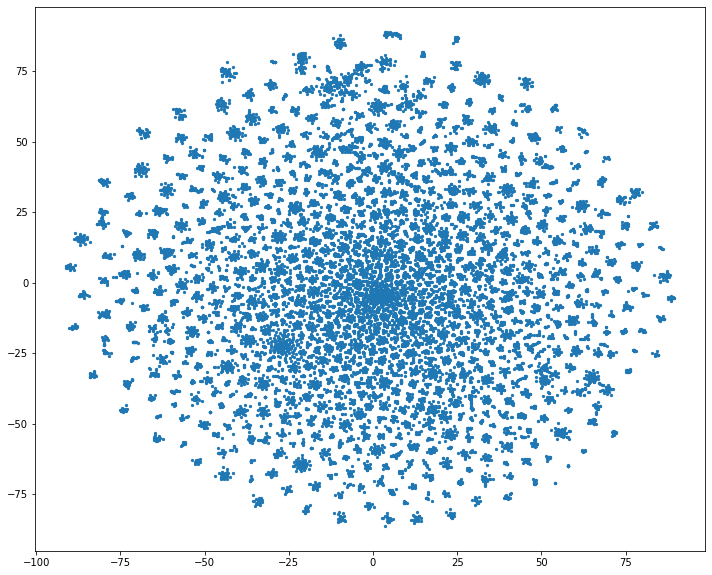

In [5]:
#On affiche les résultats
plt.figure(figsize=(12,10))
plt.scatter(X_embedded[:,0], X_embedded[:,1], s=5)
plt.show()

## Affichage des mots les plus fréquents

On va utiliser **Wordcloud** pour afficher les mots les plus fréquents dans notre corpus

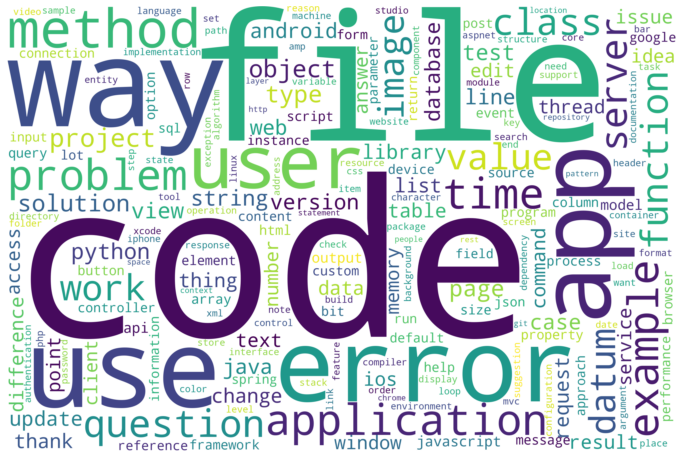

In [6]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

#On initialise le WordCloud
wordcloud = WordCloud(width = 3000, height = 2000, background_color='white', stopwords=STOPWORDS)
#On liste les fréquences d'apparition de chaque mot
counter = X.sum(axis = 0)
#On génère le wordcloud à partir de ces fréquences
wordcloud.generate_from_frequencies(counter)
#On affiche le wordcloud obtenu
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

On reconnaît immédiatement le vocabulaire du développement informatique : "code", "file", "user"... Il va nous falloir identifier des sujets un peu plus précis, à partir de choix de mots plus spécifiques que ceux-ci.

## Détection des sujets

On va utiliser l'algorithme **LDA** pour détecter les sujets sur lequels portent nos documents à partir des mots employés. Tout d'abord il va falloir générer le corpus des mots utilisés, ainsi que mettre nos textes au format supporté par la fonction *LdaModel* de *gensim*.

In [7]:
import gensim.corpora as corpora

#On prépare nos textes
textes = data["Texte_clean"].apply(lambda x: x.split(' '))
id2word = corpora.Dictionary(textes)

#On génère le corpus
corpus = []
for text in textes:
    new = id2word.doc2bow(text)
    corpus.append(new)

Nous allons chercher à identifier $30$ sujets dans notre corpus. Notons que la LDA nous donnera les mots les plus utilisés pour parler d'un sujet (avec leur probabilité d'apparition dans le sujet considéré), mais ce sera à nous d'identifier clairement de quelle idée il s'agit.

In [8]:
import gensim

#On applique le modèle LDA
lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=30, random_state=42,
                                           update_every=1, chunksize=100, passes=10, alpha='auto')
for idx, topic in lda.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.209*"python" + 0.123*"java" + 0.117*"library" + 0.097*"package" + 0.086*"window" + 0.069*"option" + 0.039*"linux" + 0.027*"windows" + 0.025*"mac" + 0.023*"os"
Topic: 1 
Words: 0.251*"database" + 0.139*"table" + 0.113*"query" + 0.106*"feature" + 0.078*"repository" + 0.034*"db" + 0.033*"record" + 0.031*"topic" + 0.024*"moment" + 0.023*"create"
Topic: 2 
Words: 0.155*"return" + 0.128*"run" + 0.123*"script" + 0.105*"part" + 0.075*"format" + 0.070*"sql" + 0.067*"date" + 0.054*"email" + 0.049*"setting" + 0.018*"body"
Topic: 3 
Words: 0.494*"user" + 0.181*"process" + 0.142*"button" + 0.051*"click" + 0.023*"pixel" + 0.000*"worker" + 0.000*"android" + 0.000*"opentk" + 0.000*"gdi" + 0.000*"sequelizejs"
Topic: 4 
Words: 0.324*"app" + 0.118*"ios" + 0.118*"view" + 0.096*"difference" + 0.073*"controller" + 0.070*"device" + 0.042*"label" + 0.040*"bar" + 0.023*"navigation" + 0.012*"render"
Topic: 5 
Words: 0.135*"page" + 0.098*"access" + 0.071*"javascript" + 0.063*"browser" + 0.059*

On peut identifier dans l'ordre les sujets suivants : 0 - "python", 1 - "base de données", 2 - "sql", 3 - "interface utilisateur", 4 - "application", 5 - "page web", 6 - "fichier", 7 - "réseau", 8 - "configuration", 9 - "http", 10 - "json", 11 - "format de variables", 12 - "gestion de projet", 13 - "google", 14 - "api", 15 - "tableau", 16 - "xml", 17 - "debugging", 18 - "ajax", 19 - "développement", 20 - "c++", 21 - "orienté objet", 22 - "excel", 23 - "c", 24 - "temps et dates", 25 - "images", 26 - "opentk", 27 - "gcc", 28 - "vidéo", 29 - "git".

Nous allons visualiser les résultats de notre LDA avec **pyLDAvis**.

In [9]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda, corpus, id2word, mds="mmds", R=30)
vis

C:\Users\monte\AppData\Roaming\Python\Python39\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
24    -0.528916  0.127505       1        1  17.407304
11     0.172932 -0.493968       2        1   7.247658
12     0.463600  0.209225       3        1   5.230674
28     0.336575  0.361260       4        1   5.124602
7      0.471653 -0.145525       5        1   4.532363
5     -0.027703 -0.485713       6        1   4.124959
17    -0.359592  0.351912       7        1   4.053169
0      0.477052  0.024087       8        1   3.789663
6     -0.443004 -0.223192       9        1   3.711220
4     -0.455673 -0.048906      10        1   3.469965
13    -0.222114  0.265334      11        1   3.448658
9     -0.183938 -0.431654      12        1   2.872351
25    -0.310451 -0.334607      13        1   2.644561
16     0.299227  0.001461      14        1   2.622874
21     0.062634  0.479673      15        1   2.613223
19     0.374047 -0.270958      16        1   2.599786
23     0.220951 -0.196178      17        1   2.513132
18    -0.353732  0.145114      18        1   2.392085
29    -0.285799 -0.135284      19        1   2.268741
2      0.062673  0.262853      20        1   2.228246
1      0.189789  0.383273      21        1   2.107119
14    -0.186172  0.433070      22        1   2.055268
15    -0.053438  0.379892      23        1   1.891468
3      0.224505 -0.342052      24        1   1.860986
20     0.270298  0.169362      25        1   1.824904
22    -0.128344 -0.240947      26        1   1.718015
10     0.027306 -0.280521      27        1   1.464002
27    -0.163633  0.033309      28        1   1.196214
8      0.060300 -0.030542      29        1   0.974472
26    -0.011033  0.032717      30        1   0.012317, topic_info=         Term          Freq         Total Category  logprob  loglift
31       file  12679.000000  12679.000000  Default  30.0000  30.0000
266     error  10610.000000  10610.000000  Default  29.0000  29.0000
2        code  19042.000000  19042.000000  Default  28.0000  28.0000
369       app   8282.000000   8282.000000  Default  27.0000  27.0000
106      user   6759.000000   6759.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
23      world      0.002749    418.865704  Topic30 -10.4031  -2.9320
24   analysis      0.002749    404.764770  Topic30 -10.4031  -2.8978
25       body      0.002749    297.706251  Topic30 -10.4031  -2.5906
26        c++      0.002749   2040.524484  Topic30 -10.4031  -4.5154
29    concept      0.002749    360.132666  Topic30 -10.4031  -2.7809

[1121 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
561      27  0.993979   ability
562       6  0.999630    access
608       4  0.996433  accuracy
347      27  0.998408    action
809      13  0.997658  activity
...     ...       ...       ...
959       7  0.986497      xaml
265      19  0.999224     xcode
807      10  0.991935       xib
585      14  0.997418       xml
899       3  0.996637      year

[645 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[25, 12, 13, 29, 8, 6, 18, 1, 7, 5, 14, 10, 26, 17, 22, 20, 24, 19, 30, 3, 2, 15, 16, 4, 21, 23, 11, 28, 9, 27])